<a href="https://colab.research.google.com/github/nikitos-net/Machine-learning-methods-for-automatic-recognition-of-fake-faces./blob/main/nn_validationV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 whi

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.applications import VGG16

from huggingface_hub import login
from datasets import load_dataset
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D, BatchNormalization, LeakyReLU, Concatenate, MaxPooling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import glob
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import EfficientNetB4
import cv2
from tensorflow.keras.preprocessing import image

In [ ]:
from huggingface_hub import hf_hub_download, list_repo_files
import os
import tarfile

repo_id = "xingjunm/WildDeepfake"
fake_dir = "deepfake_in_the_wild/fake_test"
real_dir = "deepfake_in_the_wild/real_test"
local_dir = "downloaded_data"
fake_images_folder = "extracted_fake_images"
real_images_folder = "extracted_real_images"

os.makedirs(local_dir, exist_ok=True)
os.makedirs(fake_images_folder, exist_ok=True)
os.makedirs(real_images_folder, exist_ok=True)

files = list_repo_files(repo_id, repo_type="dataset")

for file_path in files:
    target_folder = None
    if file_path.startswith(fake_dir):
        target_folder = fake_dir
        output_folder = fake_images_folder
    elif file_path.startswith(real_dir):
        target_folder = real_dir
        output_folder = real_images_folder

    if target_folder:
        local_file_path = os.path.join(local_dir, file_path[len(target_folder) + 1:])
        try:
            print(f"Скачиваем {file_path}...")
            download_path = hf_hub_download(repo_id, filename=file_path, repo_type="dataset", local_dir=local_dir)
            file_size = os.path.getsize(download_path)
            print(f"  Файл скачан, размер: {file_size} байт")

            if file_path.endswith(".tar.gz"):
                print(f"  Распаковываем {file_path} как tar (без gzip)...")
                try:
                    with tarfile.open(download_path, 'r') as tar_ref:
                        for member in tar_ref.getmembers():
                            if not member.isdir() and any(member.name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.bmp']):
                                try:
                                    image_file = tar_ref.extractfile(member)
                                    if image_file:
                                        image_data = image_file.read()
                                        local_image_path = os.path.join(output_folder, os.path.basename(member.name))
                                        with open(local_image_path, "wb") as f:
                                            f.write(image_data)
                                        #print(f"    Извлечено изображение: {member.name}")
                                except Exception as e:
                                    print(f"    Ошибка при извлечении изображения {member.name}: {e}")
                except Exception as e:
                    print(f"  Ошибка при распаковке архива {file_path}: {e}")
            else:
                print(f"  Файл {file_path} не является архивом tar.gz, пропущен")

            print(f"  Файл {file_path} обработан.")

        except Exception as e:
            print(f"Ошибка при скачивании файла {file_path}: {e}")

print("Загрузка и распаковка завершены.")

In [5]:
!rm -r /content/downloaded_data

In [6]:
def create_mesonet4():
    input_tensor = Input(shape=(256, 256, 3))

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((4, 4))(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output_tensor = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_tensor, outputs=output_tensor)
    return model


In [7]:
def InceptionLayer(a, b, c, d):
    def func(x):
        x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)

        x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
        x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)

        x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
        x3 = Conv2D(c, (3, 3), dilation_rate=2, strides=1, padding='same', activation='relu')(x3)

        x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
        x4 = Conv2D(d, (3, 3), dilation_rate=3, strides=1, padding='same', activation='relu')(x4)

        y = Concatenate(axis=-1)([x1, x2, x3, x4])

        return y
    return func


def create_mesoinception4():
    x = Input(shape=(256, 256, 3))

    x1 = InceptionLayer(1, 4, 4, 2)(x)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

    x2 = InceptionLayer(2, 4, 4, 2)(x1)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

    x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

    x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
    x4 = BatchNormalization()(x4)
    x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

    y = Flatten()(x4)
    y = Dropout(0.5)(y)
    y = Dense(16)(y)
    y = LeakyReLU(negative_slope=0.1)(y)
    y = Dropout(0.5)(y)
    y = Dense(1, activation='sigmoid')(y)

    return models.Model(inputs=x, outputs=y)

In [ ]:
def create_vgg16():
    input_tensor = Input(shape=(224, 224, 3))

    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(input_tensor)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)


    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)


    x = Flatten()(x)
    x = Dense(units=4096, activation="relu")(x)
    x = Dense(units=4096, activation="relu")(x)

    output_tensor = Dense(2, activation="softmax")(x)

    model = models.Model(inputs=input_tensor, outputs=output_tensor)
    return model

In [8]:
def create_efficientnetb4(weights_path=None):
    # Build EfficientNetB4 model
    base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Internal Data Augmentation Layer
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ])

    # Apply Data Augmentation
    input_tensor = tf.keras.layers.Input(shape=(224, 224, 3))
    x = data_augmentation(input_tensor)
    x = base_model(x, training=False) # using base model in inference mode
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_tensor = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(input_tensor, output_tensor)


    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model

In [9]:
def softmax_to_sigmoid(softmax_output):
    """Преобразует softmax выход в sigmoid используя разницу логитов."""
    if len(softmax_output) == 2:
        # Вычисляем разницу логитов
        x = softmax_output[1] - softmax_output[0]
        #применяем сигмоиду
        sigmoid_output = 1 / (1 + tf.exp(-x))
        return sigmoid_output.numpy() # Возвращаем значение как numpy
    else:
        return softmax_output

In [10]:
def invert_predict(predicts):
    return [1 - x for x in predicts]

In [11]:
def load_model(model_path):
    try:
        model = models.load_model(model_path)
        print(f"Модель успешно загружена из {model_path}")
        return model
    except Exception as e:
        print(f"Ошибка при загрузке модели из {model_path}: {e}")
        return None

In [12]:
def preprocess_image(image_path, target_size=(256, 256)):
    try:
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array
    except Exception as e:
        print(f"Ошибка при предобработке изображения {image_path}: {e}")
        return None

In [13]:
def preprocess_image_resnet(image_path, target_size=(224, 224)):
    """Предобрабатывает изображение для ResNet."""
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

def preprocess_image_inceptionv3(image_path, target_size=(299, 299)):
    """Предобрабатывает изображение для InceptionV3."""
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

def preprocess_image_efficientnet(image_path, target_size=(224, 224)):
    """Предобрабатывает изображение для EfficientNetB4."""
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

def preprocess_image_vgg16(image_path, target_size=(224, 224)):
    """Предобрабатывает изображение для VGG16."""
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def preprocess_image_mesonet(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) #/ 255.0
    img = np.expand_dims(img, axis=0)
    return img

def preprocess_image_xception(image_path, target_size=(299, 299)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32)
    img = tf.keras.applications.xception.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [14]:
def predict_deepfake(preprocessed_image, model):
    if preprocessed_image is None:
        return None # Предобработка не удалась

    if model:
        prediction = model.predict(preprocessed_image)[0] # Получаем весь вектор предсказаний
        if len(prediction) == 1: # sigmoid
            print('sig')
            return float(prediction[0]) # Преобразуем в float
        elif len(prediction) == 2: # softmax
            print('soft')
            return float(softmax_to_sigmoid(prediction)) # Преобразуем в float
        else:
            return None
    else:
        return None

In [15]:
def evaluate_model(model, image_dir, num_images=50, batch_size=32, target_size=(256, 256), preprocess_function=None):

    y_true = []
    y_pred_probs = []

    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + glob.glob(os.path.join(image_dir, "*.jpeg")) + glob.glob(os.path.join(image_dir, "*.png"))
    image_paths = image_paths[:num_images]

    for i in tqdm(range(0, len(image_paths), batch_size), desc="Evaluating"):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        batch_labels = []

        for image_path in batch_paths:
            try:
                if preprocess_function:
                    img = preprocess_function(image_path, target_size=target_size)
                else:
                    # Если функция предобработки не указана, загружаем и изменяем размер изображения
                    img = image.load_img(image_path, target_size=target_size)
                    img = image.img_to_array(img)
                    img = np.expand_dims(img, axis=0)  # Добавляем размерность батча
                    img = img / 255.0 # Normalizing in the range [0, 1]

                if img is not None:
                    batch_images.append(img)
                    label = 1 if "fake" in image_path.lower() else 0
                    batch_labels.append(label)
            except Exception as e:
                print(f"Ошибка при обработке изображения {image_path}: {e}")

        if batch_images:
            batch_images = np.vstack(batch_images)
            #batch_images = np.concatenate(batch_images, axis=0) # Изменено на concatenate
            try:
                batch_predictions = model.predict(batch_images, verbose=0)
                y_pred_probs.extend(batch_predictions[:, 0])
                y_true.extend(batch_labels)
            except Exception as e:
                print(f"Ошибка при предсказании для пакета: {e}")

    return y_true, y_pred_probs

In [16]:
mesonet4_model = create_mesonet4()
try:
    mesonet4_model.load_weights('/content/drive/MyDrive/models/Meso4.h5')
    print("Веса успешно загружены из /content/drive/MyDrive/models/Meso4.h5")
except Exception as e:
    print(f"Ошибка при загрузке весов: {e}")
    mesonet4_model = None

mesonet4_model.summary()

Веса успешно загружены из /content/drive/MyDrive/models/Meso4.h5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 8)         │           1,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          16,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

In [17]:
mesoinception4_model = create_mesoinception4()
try:
    mesoinception4_model.load_weights('/content/drive/MyDrive/models/MesoInception.h5')
    print("Веса успешно загружены из /content/drive/MyDrive/models/MesoInception.h5")
except Exception as e:
    print(f"Ошибка при загрузке весов: {e}")
    mesoinception4_model = None

mesoinception4_model.summary()

Веса успешно загружены из /content/drive/MyDrive/models/MesoInception.h5


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 4)    │             16 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 256, 256, 4)    │             16 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 256, 256, 2)    │              8 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 1)    │              4 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 256, 256, 4)    │            148 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 4)    │            148 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 256, 256, 2)    │             38 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256, 256, 11)   │              0 │ conv2d_4[0][0],        │
│                           │                        │                │ conv2d_6[0][0],        │
│                           │                        │                │ conv2d_8[0][0],        │
│                           │                        │                │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 256, 256, 11)   │             44 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 11)   │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 128, 128, 4)    │             48 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 128, 128, 4)    │             48 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 128, 128, 2)    │             24 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 128, 128, 2)    │             24 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 128, 128, 4)    │            148 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)   

 Total params: 28,725 (112.21 KB)

 Trainable params: 28,615 (111.78 KB)

 Non-trainable params: 110 (440.00 B)

In [ ]:
resnet50_model_1 = load_model('/content/drive/MyDrive/models/Res_01.keras')
if resnet50_model_1:
    resnet50_model_1.summary()

Модель успешно загружена из /content/drive/MyDrive/models/Res_01.keras


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051,013 (271.04 MB)

 Trainable params: 23,665,921 (90.28 MB)

 Non-trainable params: 53,248 (208.00 KB)

 Optimizer params: 47,331,844 (180.56 MB)

In [ ]:
resnet50_model_2 = load_model('/content/drive/MyDrive/models/Res_02.keras')
if resnet50_model_2:
    resnet50_model_2.summary()

Модель успешно загружена из /content/drive/MyDrive/models/Res_02.keras


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,115,333 (282.73 MB)

 Trainable params: 24,687,233 (94.17 MB)

 Non-trainable params: 53,632 (209.50 KB)

 Optimizer params: 49,374,468 (188.35 MB)

In [ ]:
inceptionv3_model = load_model('/content/drive/MyDrive/models/ICV3.keras')
if inceptionv3_model:
    inceptionv3_model.summary()

Модель успешно загружена из /content/drive/MyDrive/models/ICV3.keras


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,986,981 (263.16 MB)

 Trainable params: 22,983,585 (87.68 MB)

 Non-trainable params: 36,224 (141.50 KB)

 Optimizer params: 45,967,172 (175.35 MB)

In [ ]:
xception_model = load_model('/content/drive/MyDrive/models/Xception.keras')
if inceptionv3_model:
    inceptionv3_model.summary()

Модель успешно загружена из /content/drive/MyDrive/models/Xception.keras


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,986,981 (263.16 MB)

 Trainable params: 22,983,585 (87.68 MB)

 Non-trainable params: 36,224 (141.50 KB)

 Optimizer params: 45,967,172 (175.35 MB)

In [ ]:
vgg16_model = create_vgg16()
try:
    vgg16_model.load_weights('/content/drive/MyDrive/models/VGG16.h5')
    print("Веса успешно загружены из /content/drive/MyDrive/models/VGG16.h5")
except Exception as e:
    print(f"Ошибка при загрузке весов: {e}")
    vgg16_model = None

vgg16_model.summary()

Веса успешно загружены из /content/drive/MyDrive/models/VGG16.h5


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 512)           │           2,0

 Total params: 134,271,042 (512.20 MB)

 Trainable params: 134,269,890 (512.20 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
efficientnetb4_model = create_efficientnetb4()
try:
    efficientnetb4_model.load_weights('/content/drive/MyDrive/models/EfficientNetB4.h5')
    print("Веса успешно загружены из /content/drive/MyDrive/models/EfficientNetB4.h5")
except Exception as e:
    print(f"Ошибка при загрузке весов: {e}")
    efficientnetb4_model = None

efficientnetb4_model.summary()

Веса успешно загружены из /content/drive/MyDrive/models/EfficientNetB4.h5


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_11 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 7, 7, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_17          │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │           1,793 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,675,616 (67.43 MB)

 Trainable params: 17,550,409 (66.95 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [19]:
fake_dir = "extracted_fake_images"
real_dir = "extracted_real_images"
num_images=2048
batch_size=32


Оценка Xception:
Поддельные изображения:


Evaluating: 100%|██████████| 64/64 [15:48<00:00, 14.82s/it]


Реальные изображения:


Evaluating: 100%|██████████| 64/64 [15:06<00:00, 14.16s/it]


  ROC AUC: 0.5200


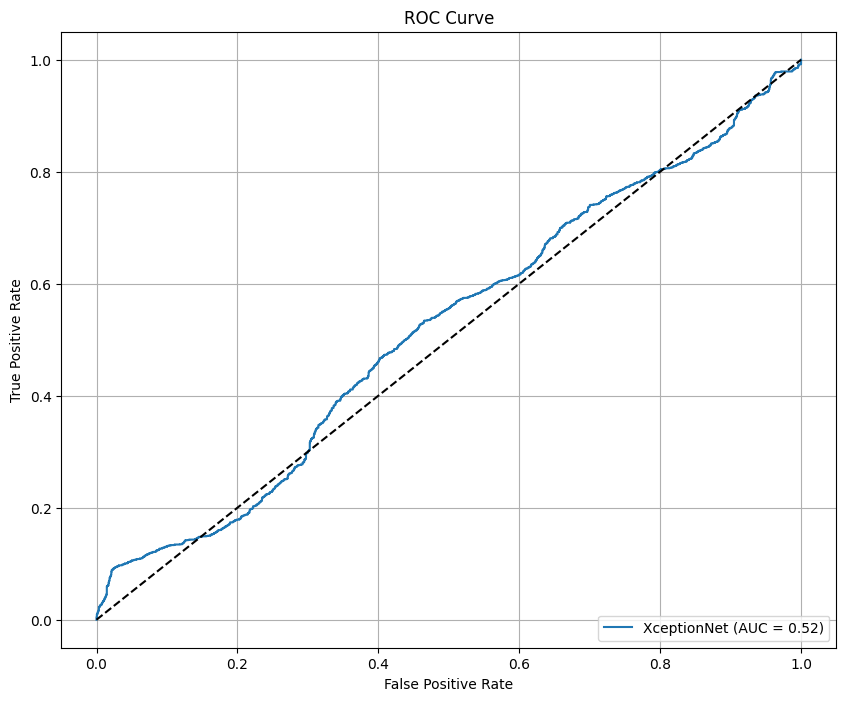

In [ ]:
print("\nОценка Xception:")

print("Поддельные изображения:")
y_true_xception, y_pred_probs_xception = evaluate_model(
    xception_model,
    fake_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(256, 256),
    preprocess_function=preprocess_image_xception
)

print("Реальные изображения:")
y_true_xception_real, y_pred_probs_xception_real = evaluate_model(
    xception_model,
    real_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(256, 256),
    preprocess_function=preprocess_image_xception
)

y_true_xception.extend(y_true_xception_real)
y_pred_probs_xception.extend(y_pred_probs_xception_real)

roc_auc_xception = roc_auc_score(y_true_xception, y_pred_probs_xception)
print(f"  ROC AUC: {roc_auc_xception:.4f}")

fpr_xception, tpr_xception, thresholds_xception = roc_curve(y_true_xception, y_pred_probs_xception)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xception, tpr_xception, label=f'XceptionNet (AUC = {roc_auc_xception:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Оценка Mesonet4:
Поддельные изображения:


Evaluating: 100%|██████████| 250/250 [04:13<00:00,  1.01s/it]


Реальные изображения:


Evaluating: 100%|██████████| 250/250 [04:04<00:00,  1.02it/s]


  ROC AUC: 0.5041


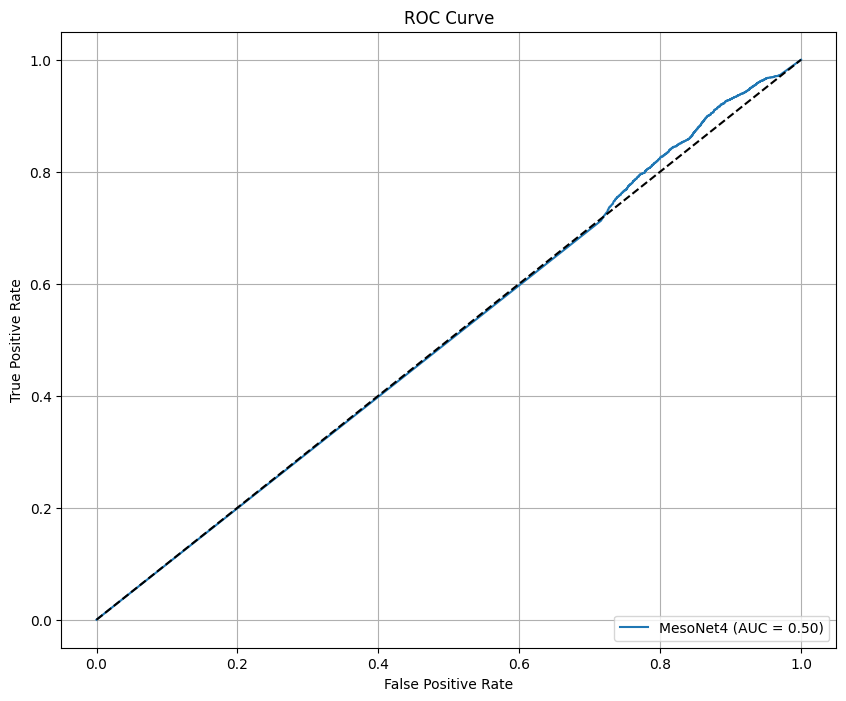

In [22]:
print("Оценка Mesonet4:")

print("Поддельные изображения:")
y_true_meso, y_pred_probs_meso = evaluate_model(
    mesonet4_model,
    fake_dir,
    num_images=8000,
    batch_size=batch_size,
    target_size=(256, 256),
    preprocess_function=preprocess_image_mesonet
)

print("Реальные изображения:")
y_true_meso_real, y_pred_probs_meso_real = evaluate_model(
    mesonet4_model,
    real_dir,
    num_images=8000,
    batch_size=batch_size,
    target_size=(256, 256),
    preprocess_function=preprocess_image_mesonet
)

y_true_meso.extend(y_true_meso_real)
y_pred_probs_meso.extend(y_pred_probs_meso_real)
#y_pred_probs_meso = invert_predict(y_pred_probs_meso)

roc_auc_meso = roc_auc_score(y_true_meso, y_pred_probs_meso)
print(f"  ROC AUC: {roc_auc_meso:.4f}")

fpr_meso, tpr_meso, thresholds_meso = roc_curve(y_true_meso, y_pred_probs_meso)

plt.figure(figsize=(10, 8))
plt.plot(fpr_meso, tpr_meso, label=f'MesoNet4 (AUC = {roc_auc_meso:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Оценка MesoInception4:
Поддельные изображения:


Evaluating: 100%|██████████| 250/250 [12:07<00:00,  2.91s/it]


Реальные изображения:


Evaluating: 100%|██████████| 250/250 [11:55<00:00,  2.86s/it]


  ROC AUC: 0.4184


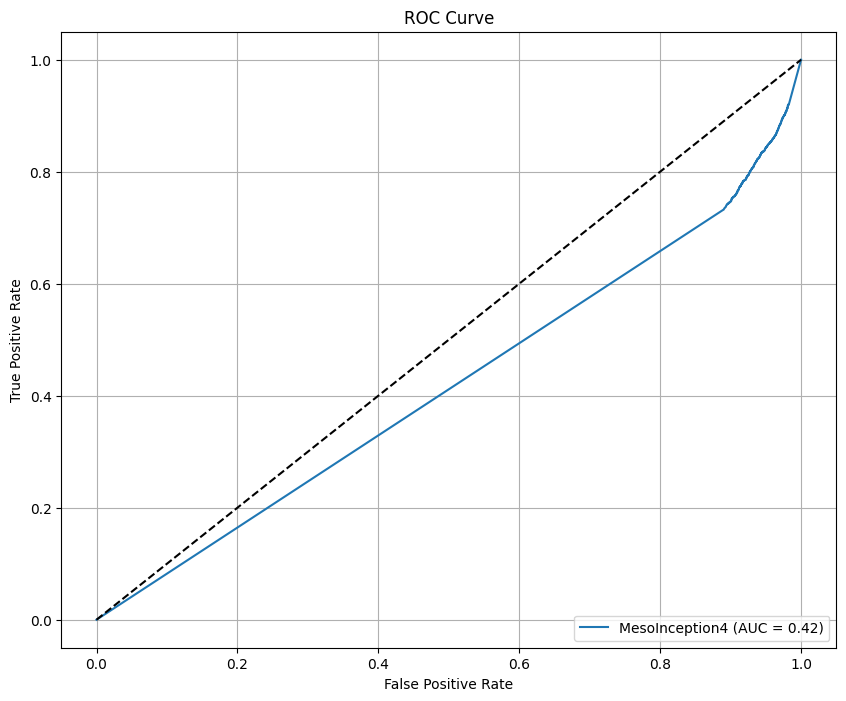

In [23]:
print("Оценка MesoInception4:")

print("Поддельные изображения:")
y_true_mesoincep, y_pred_probs_mesoincep = evaluate_model(
    mesoinception4_model,
    fake_dir,
    num_images=8000,
    batch_size=batch_size,
    target_size=(256, 256),
    preprocess_function=preprocess_image_mesonet
)

print("Реальные изображения:")
y_true_mesoincep_real, y_pred_probs_mesoincep_real = evaluate_model(
    mesoinception4_model,
    real_dir,
    num_images=8000,
    batch_size=batch_size,
    target_size=(256, 256),
    preprocess_function=preprocess_image_mesonet
)

y_true_mesoincep.extend(y_true_mesoincep_real)
y_pred_probs_mesoincep.extend(y_pred_probs_mesoincep_real)
#y_pred_probs_mesoincep = invert_predict(y_pred_probs_mesoincep)

roc_auc_mesoincep = roc_auc_score(y_true_mesoincep, y_pred_probs_mesoincep)
print(f"  ROC AUC: {roc_auc_mesoincep:.4f}")

fpr_mesoincep, tpr_mesoincep, thresholds_mesoincep = roc_curve(y_true_mesoincep, y_pred_probs_mesoincep)

plt.figure(figsize=(10, 8))
plt.plot(fpr_mesoincep, tpr_mesoincep, label=f'MesoInception4 (AUC = {roc_auc_mesoincep:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Оценка ResNet50_1:
Поддельные изображения:


Evaluating: 100%|██████████| 64/64 [09:05<00:00,  8.52s/it]


Реальные изображения:


Evaluating: 100%|██████████| 64/64 [09:22<00:00,  8.78s/it]


  ROC AUC: 0.5000


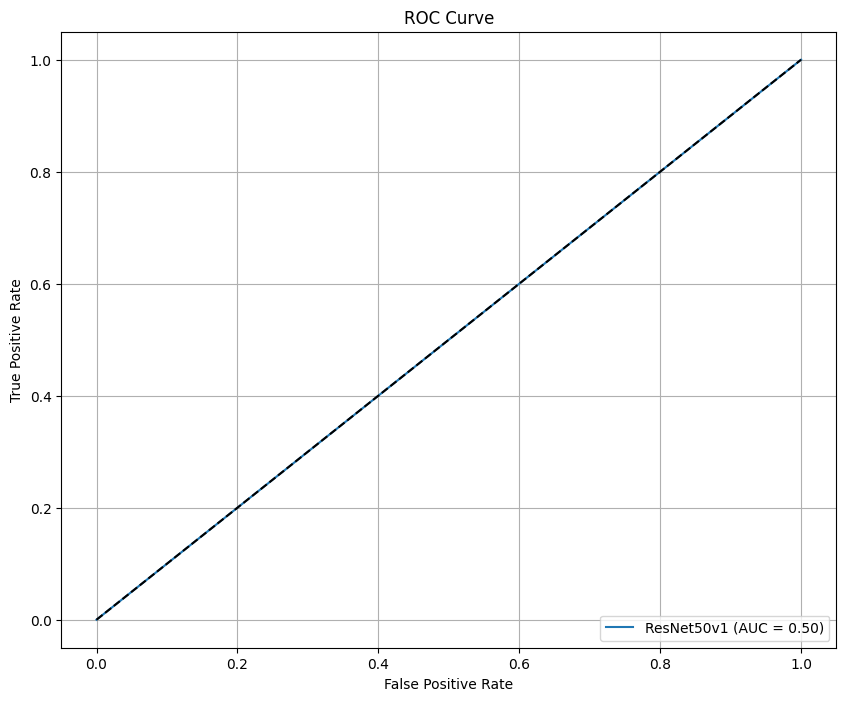

In [ ]:
print("\nОценка ResNet50_1:")

print("Поддельные изображения:")
y_true_resnet1, y_pred_probs_resnet1 = evaluate_model(
    resnet50_model_1,
    fake_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(224, 224),  # Укажите правильный target_size
    preprocess_function=preprocess_image_resnet  # Укажите функцию предобработки для EfficientNetB4
)

print("Реальные изображения:")
y_true_resnet1_real, y_pred_probs_resnet1_real = evaluate_model(
    resnet50_model_1,
    real_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(224, 224),  # Укажите правильный target_size
    preprocess_function=preprocess_image_resnet  # Укажите функцию предобработки для EfficientNetB4
)

y_true_resnet1.extend(y_true_resnet1_real)
y_pred_probs_resnet1.extend(y_pred_probs_resnet1_real)

roc_auc_resnet1 = roc_auc_score(y_true_resnet1, y_pred_probs_resnet1)
print(f"  ROC AUC: {roc_auc_resnet1:.4f}")

fpr_resnet1, tpr_resnet1, thresholds_resnet1 = roc_curve(y_true_resnet1, y_pred_probs_resnet1)

plt.figure(figsize=(10, 8))
plt.plot(fpr_resnet1, tpr_resnet1, label=f'ResNet50v1 (AUC = {roc_auc_resnet1:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Оценка ResNet50_2:
Поддельные изображения:


Evaluating: 100%|██████████| 64/64 [09:40<00:00,  9.07s/it]


Реальные изображения:


Evaluating: 100%|██████████| 64/64 [09:10<00:00,  8.60s/it]


  ROC AUC: 0.5670


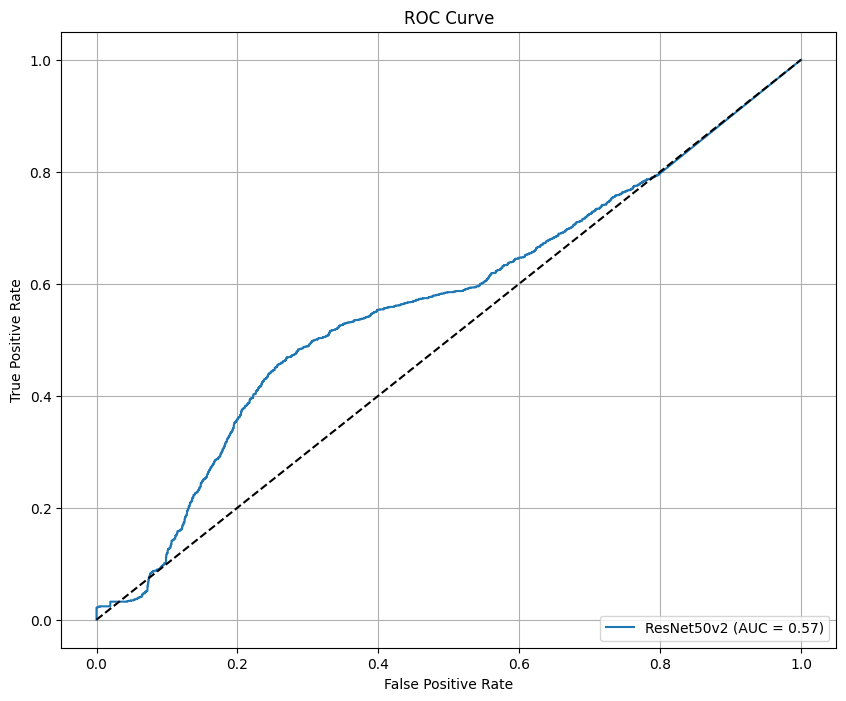

In [ ]:
print("\nОценка ResNet50_2:")

print("Поддельные изображения:")
y_true_resnet1, y_pred_probs_resnet1 = evaluate_model(
    resnet50_model_2,
    fake_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(224, 224),  # Укажите правильный target_size
    preprocess_function=preprocess_image_resnet  # Укажите функцию предобработки для EfficientNetB4
)

print("Реальные изображения:")
y_true_resnet1_real, y_pred_probs_resnet1_real = evaluate_model(
    resnet50_model_2,
    real_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(224, 224),  # Укажите правильный target_size
    preprocess_function=preprocess_image_resnet  # Укажите функцию предобработки для EfficientNetB4
)

y_true_resnet1.extend(y_true_resnet1_real)
y_pred_probs_resnet1.extend(y_pred_probs_resnet1_real)

roc_auc_resnet1 = roc_auc_score(y_true_resnet1, y_pred_probs_resnet1)
print(f"  ROC AUC: {roc_auc_resnet1:.4f}")

fpr_resnet1, tpr_resnet1, thresholds_resnet1 = roc_curve(y_true_resnet1, y_pred_probs_resnet1)

plt.figure(figsize=(10, 8))
plt.plot(fpr_resnet1, tpr_resnet1, label=f'ResNet50v2 (AUC = {roc_auc_resnet1:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Оценка InceptionV3:
Поддельные изображения:


Evaluating: 100%|██████████| 64/64 [07:03<00:00,  6.61s/it]


Реальные изображения:


Evaluating: 100%|██████████| 64/64 [07:16<00:00,  6.82s/it]


  ROC AUC: 0.5626


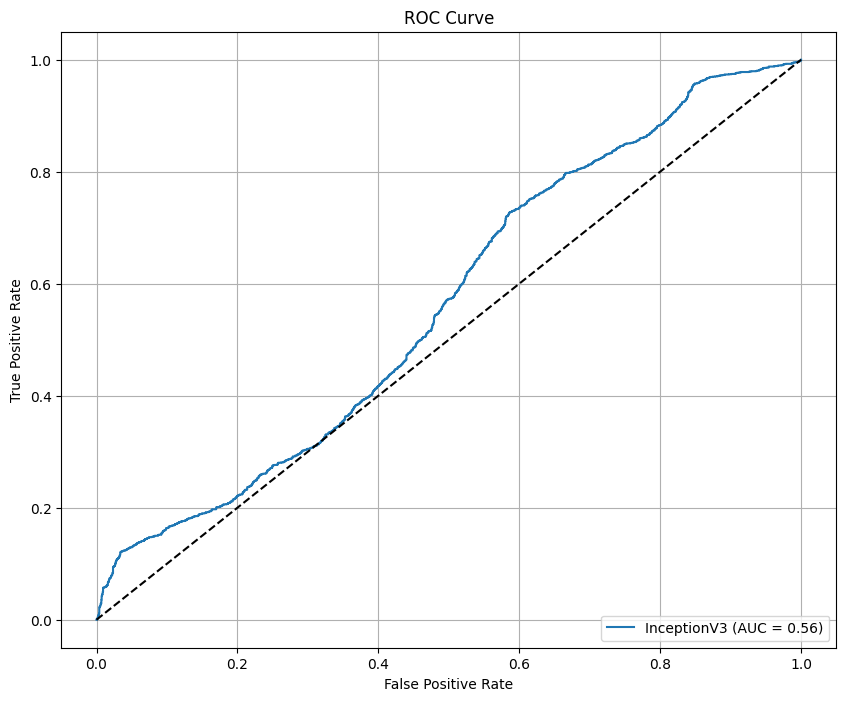

In [ ]:
print("\nОценка InceptionV3:")

print("Поддельные изображения:")
y_true_inception, y_pred_probs_inception = evaluate_model(
    inceptionv3_model,
    fake_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(224, 224),  # Укажите правильный target_size
    preprocess_function=preprocess_image_inceptionv3  # Укажите функцию предобработки для EfficientNetB4
)

print("Реальные изображения:")
y_true_inception_real, y_pred_probs_inception_real = evaluate_model(
    inceptionv3_model,
    real_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(224, 224),  # Укажите правильный target_size
    preprocess_function=preprocess_image_inceptionv3  # Укажите функцию предобработки для EfficientNetB4
)

y_true_inception.extend(y_true_inception_real)
y_pred_probs_inception.extend(y_pred_probs_inception_real)

roc_auc_inception = roc_auc_score(y_true_inception, y_pred_probs_inception)
print(f"  ROC AUC: {roc_auc_inception:.4f}")

fpr_inception, tpr_inception, thresholds_inception = roc_curve(y_true_inception, y_pred_probs_inception)

plt.figure(figsize=(10, 8))
plt.plot(fpr_inception, tpr_inception, label=f'InceptionV3 (AUC = {roc_auc_inception:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Оценка VGG16:
Поддельные изображения:


Evaluating: 100%|██████████| 64/64 [38:24<00:00, 36.01s/it]


Реальные изображения:


Evaluating: 100%|██████████| 64/64 [39:04<00:00, 36.63s/it]


  ROC AUC: 0.5919


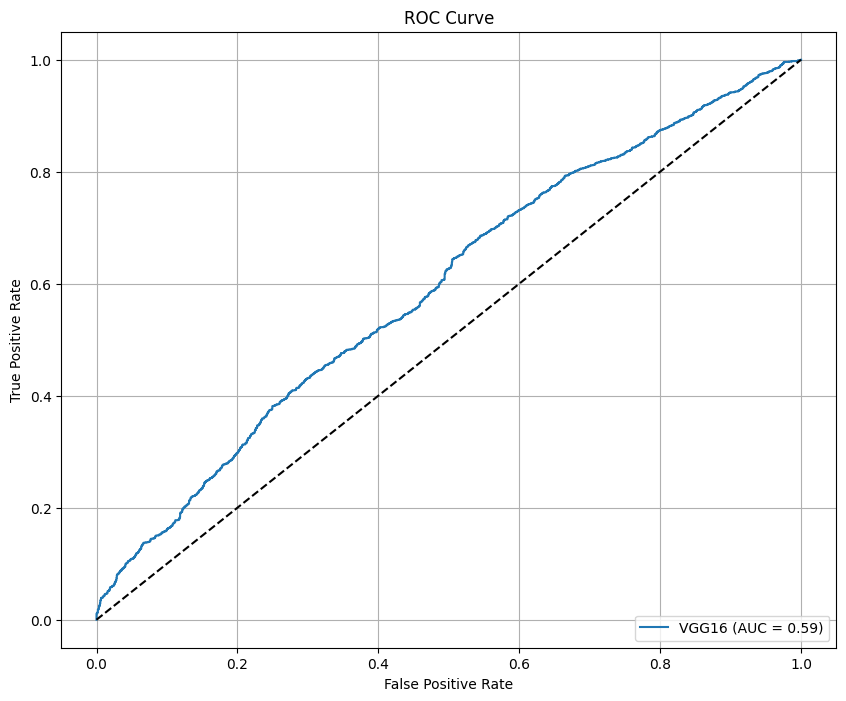

In [ ]:
print("\nОценка VGG16:")

print("Поддельные изображения:")
y_true_vgg16, y_pred_probs_vgg16 = evaluate_model(
    vgg16_model,
    fake_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(224, 224),  # Укажите правильный target_size
    preprocess_function=preprocess_image_vgg16  # Укажите функцию предобработки для EfficientNetB4
)

print("Реальные изображения:")
y_true_vgg16_real, y_pred_probs_vgg16_real = evaluate_model(
    vgg16_model,
    real_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(224, 224),  # Укажите правильный target_size
    preprocess_function=preprocess_image_vgg16  # Укажите функцию предобработки для EfficientNetB4
)

y_true_vgg16.extend(y_true_vgg16_real)
y_pred_probs_vgg16.extend(y_pred_probs_vgg16_real)
roc_auc_vgg16 = roc_auc_score(y_true_vgg16, y_pred_probs_vgg16)
print(f"  ROC AUC: {roc_auc_vgg16:.4f}")

fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(y_true_vgg16, y_pred_probs_vgg16)

plt.figure(figsize=(10, 8))
plt.plot(fpr_vgg16, tpr_vgg16, label=f'VGG16 (AUC = {roc_auc_vgg16:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Оценка EfficientNetB4:
Поддельные изображения:


Evaluating: 100%|██████████| 64/64 [10:47<00:00, 10.11s/it]


Реальные изображения:


Evaluating: 100%|██████████| 64/64 [10:05<00:00,  9.45s/it]


  ROC AUC: 0.7909


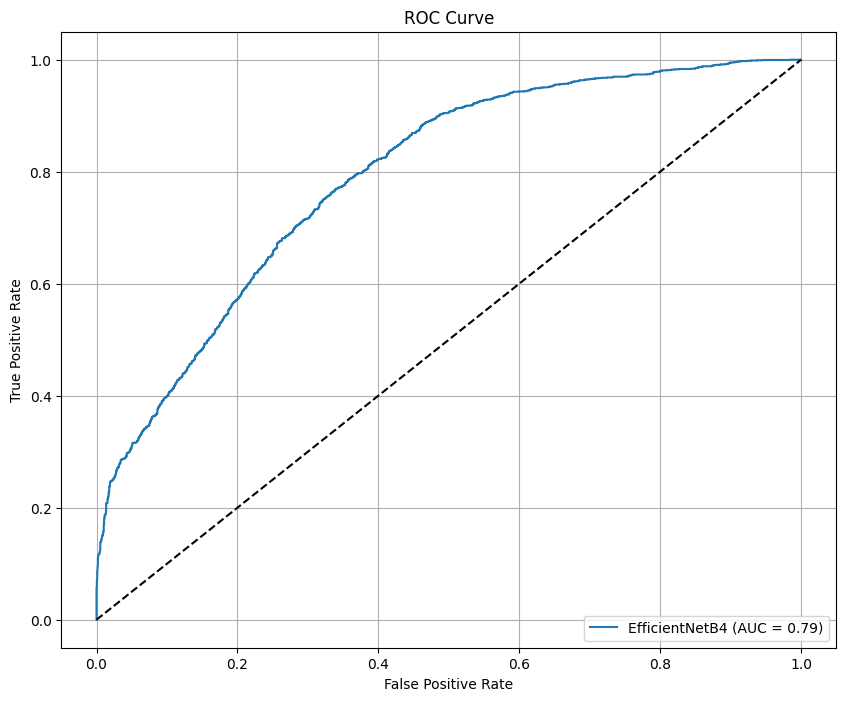

In [ ]:
print("Оценка EfficientNetB4:")

print("Поддельные изображения:")
y_true_effnet, y_pred_probs_effnet = evaluate_model(
    efficientnetb4_model,
    fake_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(224, 224),  # Укажите правильный target_size
    preprocess_function=preprocess_image_efficientnet  # Укажите функцию предобработки для EfficientNetB4
)

print("Реальные изображения:")
y_true_effnet_real, y_pred_probs_effnet_real = evaluate_model(
    efficientnetb4_model,
    real_dir,
    num_images=num_images,
    batch_size=batch_size,
    target_size=(224, 224),  # Укажите правильный target_size
    preprocess_function=preprocess_image_efficientnet  # Укажите функцию предобработки для EfficientNetB4
)

y_true_effnet.extend(y_true_effnet_real)
y_pred_probs_effnet.extend(y_pred_probs_effnet_real)
roc_auc_effnet = roc_auc_score(y_true_effnet, y_pred_probs_effnet)
print(f"  ROC AUC: {roc_auc_effnet:.4f}")

fpr_effnet, tpr_effnet, thresholds_effnet = roc_curve(y_true_effnet, y_pred_probs_effnet)

plt.figure(figsize=(10, 8))
plt.plot(fpr_effnet, tpr_effnet, label=f'EfficientNetB4 (AUC = {roc_auc_effnet:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
    y_pred_probs_xception = invert_predict(y_pred_probs_xception)
    y_pred_probs_meso = invert_predict(y_pred_probs_meso)
    y_pred_probs_resnet1 = invert_predict(y_pred_probs_resnet1)
    y_pred_probs_inception = invert_predict(y_pred_probs_inception)
    y_pred_probs_vgg16 = invert_predict(y_pred_probs_vgg16)

    roc_auc_xception = roc_auc_score(y_true_xception, y_pred_probs_xception)
    roc_auc_meso = roc_auc_score(y_true_meso, y_pred_probs_meso)
    roc_auc_resnet1 = roc_auc_score(y_true_resnet1, y_pred_probs_resnet1)
    roc_auc_inception = roc_auc_score(y_true_inception, y_pred_probs_inception)
    roc_auc_vgg16 = roc_auc_score(y_true_vgg16, y_pred_probs_vgg16)

    fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(y_true_vgg16, y_pred_probs_vgg16)

    fpr_meso, tpr_meso, thresholds_meso = roc_curve(y_true_meso, y_pred_probs_meso)

    fpr_resnet1, tpr_resnet1, thresholds_resnet1 = roc_curve(y_true_resnet1, y_pred_probs_resnet1)

    fpr_inception, tpr_inception, thresholds_inception = roc_curve(y_true_inception, y_pred_probs_inception)

    fpr_xception, tpr_xception, thresholds_xception = roc_curve(y_true_xception, y_pred_probs_xception)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr_meso, tpr_meso, label=f'MesoNet4 (AUC = {roc_auc_meso:.2f})')
    plt.plot(fpr_resnet1, tpr_resnet1, label=f'ResNet50 (AUC = {roc_auc_resnet1:.2f})')
    plt.plot(fpr_inception, tpr_inception, label=f'InceptionV3 (AUC = {roc_auc_inception:.2f})')
    plt.plot(fpr_vgg16, tpr_vgg16, label=f'VGG16 (AUC = {roc_auc_vgg16:.2f})')
    plt.plot(fpr_xception, tpr_xception, label=f'XceptionNet (AUC = {roc_auc_xception:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()